In [1]:
import os
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import PandasTools
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import numpy as np
import constants as c
import random


In [10]:
#define PairData Class
class PairData(Data):
    """Externsion of the Pytorch Geometric Data Class, which additionally takes a conjugated molecules in form of the edge_index2 and x2 input"""
    def __init__(self, edge_index, x, edge_index2, x2):
        super(PairData, self).__init__()
        self.edge_index = edge_index
        self.x = x
        self.edge_index2 = edge_index2
        self.x2 = x2

    def __inc__(self, key, value):
        if key == 'edge_index':
            return self.x.size(0)
        if key == 'edge_index2':
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)

# Functions for converting Dataframe object to PyG Dataset
def make_nodes(mol, marvin_atom, n_features):
    """Take a rdkit.Mol, the atom index of the reaction center and a dict of node feature functions. 
    
    Return a torch.tensor with dimensions num_nodes(atoms) x num_node_features.
    """
    x = []
    i = 0
    for atom in mol.GetAtoms():
        node = []
        for feat in n_features.values():
            node.append(feat(atom, i, marvin_atom))
        x.append(node)
        i += 1
    return torch.tensor(np.array([np.array(xi) for xi in x]), dtype=torch.float)

def make_edges_and_attr(mol, e_features):
    """Take a rdkit.Mol and a dict of edge feature functions. 
    
    Return a torch.tensor with dimensions 2 x num_edges
    and a torch.tensor with dimensions num_edges x num_edge_features.
    """
    edges = []
    edge_attr = []
    for bond in mol.GetBonds():
        edges.append(
            np.array(
                [
                    [bond.GetBeginAtomIdx()],
                    [bond.GetEndAtomIdx()],
                ]
            )
        )
        edge = []
        for feat in e_features.values():
            edge.append(feat(bond))
        edge_attr.append(edge)
        
    edge_index = torch.tensor(np.hstack(np.array(edges)), dtype=torch.long)
    edge_attr = torch.tensor(np.array(edge_attr), dtype=torch.float)
    return edge_index, edge_attr

def mol_to_pairdata(row, n_features, e_features):
    """Take a DataFrame row, a dict of node feature functions and a dict of edge feature functions
    and return a Pytorch PairData object.
    """
    x_p = make_nodes(row.protonated, row.marvin_atom, n_features)
    edge_index_p, edge_attr_p = make_edges_and_attr(row.protonated, e_features)
    
    x_d = make_nodes(row.deprotonated, row.marvin_atom, n_features)
    edge_index_d, edge_attr_d = make_edges_and_attr(row.deprotonated, e_features)
    #return PairData(edge_index=edge_index_p, x=x_p, edge_index2=edge_index_d, x2=x_d, edge_attr=edge_attr_p, edge_attr2=edge_attr_d).to(device=device)
    data = PairData(edge_index_p, x_p, edge_index_d, x_d)
    data.edge_attr = edge_attr_p
    data.edge_attr2 = edge_attr_d
    return data

def mol_to_singledata(row, n_features, e_features):
    """Take a DataFrame row, a dict of node feature functions and a dict of edge feature functions
    and return a Pytorch Data object.
    """
    x = make_nodes(row.protonated, row.marvin_atom, n_features)
    edge_index, edge_attr = make_edges_and_attr(row.protonated, e_features)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def make_features_dicts(all_features, feat_list):
    """Take a dict of all features and a list of strings with all disered features
    and return a dict with these features
    """
    return {x:all_features[x] for x in feat_list}

def load_data(dataset, id_list):
    """Take a list of PyG Data objects and a list of molecule ids 
    and return a list of only the PyG Data objects that are in the list of ids. 
    """
    load_data =[]
    for data in dataset:
        if data.ID in id_list:
            load_data.append(data)
    return load_data

def make_pyg_dataset(df, list_n, list_e, Paired=False):
    """Take a Dataframe, a list of strings of node features, a list of strings of edge features
    and return a List of PyG Data objects.
    
    Optional PairData by setting Paired=True.
    """
    n_feat = make_features_dicts(c.NODE_FEATURES, list_n)
    e_feat = make_features_dicts(c.EDGE_FEATURES, list_e)
    dataset = []
    if Paired:
        func = mol_to_pairdata
    else:
        func = mol_to_singledata
    for i in range(len(df.index)):
        dataset.append(func(df.iloc[i], n_feat, e_feat))
        dataset[i].y = torch.tensor([float(df.pKa[i])], dtype=torch.float32)
        dataset[i].ID = df.ID[i]
    return dataset

#Train/Test Split PyG Datasets

def pyg_split(dataset,train_test_split, shuffle=True):
    """Take List of PyG Data oojcts and a split ratio between 0 and 1 
    and return a list of Training data and a list of test data.
    """
    if shuffle:
        random.shuffle(dataset)
    
    split_length=int(len(dataset)*train_test_split)
    train_dataset = dataset[:split_length]
    test_dataset = dataset[split_length:]
    return train_dataset, test_dataset



#PyG Dataset to Dataloader 
def dataset_to_dataloader(data, shuffle=False):
    """Take a PyG Dataset and return a Dataloader object.
    
    batch_size must be defined.
    Optional shuffle can be enabled.
    """
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, follow_batch=['x', 'x2'])

# PyG Dataset Split an send to loader
def pyg_split_to_loaders(dataset,train_test_split, shuffle=False):
    """Take a PyG Dataset and split ratio between 0 and 1 
    and return train_loader and test_loader.  
    """
    if shuffle:
        random.shuffle(dataset)
    
    if train_test_split == 0 or train_test_split == 1:
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, follow_batch=['x', 'x2'])
    
    else:
        split_length=int(len(dataset)*train_test_split)
        train_dataset = dataset[:split_length]
        test_dataset = dataset[split_length:]

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, follow_batch=['x', 'x2'])
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, follow_batch=['x', 'x2'])
        return train_loader, test_loader

#Model package imports
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import global_add_pool
from torch import optim
    
#Model Class:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1)

        num_features = dataset[0].num_features
        num_edge_features = dataset[0].num_edge_features


        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, dataset[0].num_node_features* 96))
        self.conv1 = NNConv(dataset[0].num_node_features, 96, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, 96* hidden_channels))
        self.conv2 = NNConv(96, hidden_channels, nn=nn)
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, hidden_channels* hidden_channels))
        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.conv4 = NNConv(hidden_channels, hidden_channels, nn=nn)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_attr, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr)
        x = x.relu()
        # 2. Readout layer
        x = global_mean_pool(x, batch.to(device=device))  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        #x = x.relu() + 0.000001

        return x
    
def update_checkpoint(checkpoint,epoch,model, optimizer, update, checkpoint_path):
    """Take checkpoint, epoch, model, optimizer, update string and checkpoint path.
    Save checkpoint and return checkpoint object.
    """
    checkpoint['epoch']=epoch
    checkpoint['model_state']=model
    checkpoint['optimizer_state']=optimizer
    checkpoint['progress']+= update + '\n'
    torch.save(checkpoint,checkpoint_path)
    return checkpoint

# Attribution visualisation

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib.pyplot as plt
%matplotlib inline

def calc_importances(ig, dataset, sample_size):
    """Take Integrated Gradients Object, PyG Dataset and desired sample size. 
    Return two np.arrays of importances of nodes and edges, respectivly.
    """
    attr_n = np.empty((0,dataset[0].num_features))
    attr_e = np.empty((0,dataset[0].num_edge_features))
    i = 0
    for input_data in random.sample(dataset, sample_size):
        _attr, _delta = ig.attribute((input_data.x, input_data.edge_attr),additional_forward_args=(input_data.edge_index, torch.zeros(input_data.x.shape[0], dtype=int).to(device)), internal_batch_size=input_data.x.shape[0], return_convergence_delta=True)
        attr_n = np.append(attr_n, _attr[0].detach().numpy(), axis=0)
        attr_e = np.append(attr_e, _attr[1].detach().numpy(), axis=0)
        if i%5==0:
            print(f'{i+1} of {sample_size}')
        i += 1
    return attr_n, attr_e

def visualize_importances(node_feature_names, edge_feature_names, node_importances, edge_importances,  title="Average Feature Importances", plot=True, axis_title="Features"):
    """Return a figure with barplots of the feature importances."""
    feature_names = node_feature_names + edge_feature_names
    importances = np.concatenate((node_importances, edge_importances))
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        fig = plt.figure(figsize=(15,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        fig.tight_layout()
        plt.show()
        plt.close()

def show_importances_distribution(node_features, node_attributions, edge_features, edge_attributions, cols=4):
    """Return a figures with the distribution of the feature importances of all tested samples."""
    i = 1
    nr_plots = len(node_features + edge_features)
    rows = nr_plots // cols + (nr_plots / cols > 0)
    plt.figure(figsize=(cols*5,rows*4))
    for n in range(len(node_features)):
        plt.subplot(rows,cols,i)
        plt.hist(node_attributions[:,n], 100);
        plt.title(f"Attribution of {node_features[n]}");
        #plt.show()
        i += 1
    for n in range(len(edge_features)):
        plt.subplot(rows,cols,i)
        plt.hist(edge_attributions[:,n], 100);
        plt.title(f"Attribution of {edge_features[n]}");
        #plt.show()
        i += 1
    plt.show()

In [11]:
#Hyperparameters
node_features = [
    'atomic_number',
    'formal_charge',
    'chiral_tag',
    'hybridization',
    'explicit_Hs_number',
    'aromatic_tag',
    'total_valence',
    'total_degree',
    'marvin_atom'
]

edge_features = [
    'bond_type', 
    'is_conjugated'
]

train_test_split = 0.8
batch_size = 32
learning_rate=0.001
num_epochs = 200
device="cpu"
checkpoint_path = 'modelsaves/1/'

In [13]:
# load dataframe
with open('data/pandas_df/pd_all_datasets.pkl', 'rb') as pickle_file:
    pd_dataset = pickle.load(pickle_file)
# make pyG Dataset    
dataset = make_pyg_dataset(pd_dataset['Training'], node_features, edge_features, Paired=False)
# split dataset
train_data, test_data = pyg_split(dataset, train_test_split)
# make loaders
train_loader = dataset_to_dataloader(train_data)
test_loader = dataset_to_dataloader(test_data)
#print(dataset[0].ID,dataset[0], '\n\n' ,dataset[0].x,'\n\n', dataset[0].edge_index, dataset[0].y)

In [14]:
# create Single model
model = GCN(hidden_channels=32).to(device=device)
print(model)

GCN(
  (conv1): NNConv(9, 96, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=864, bias=True)
  ))
  (conv2): NNConv(96, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3072, bias=True)
  ))
  (conv3): NNConv(32, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1024, bias=True)
  ))
  (conv4): NNConv(32, 32, aggr="add", nn=Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1024, bias=True)
  ))
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


In [15]:
#Single Model
params = list(model.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

def train(loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        out = model(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        
def test(loader):
    model.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches

# save first checkpoint
checkpoint = {
    'epoch': 0,
    'model_state': model,
    'optimizer_state': optimizer,
    'training_data': [train_data[i].ID for i in range(len(train_data))],
    'test_data': [test_data[i].ID for i in range(len(test_data))],
    'node_features': node_features,
    'edge_features': edge_features,
    'progress':'', 
}
torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch_0')

In [16]:
#load checkpoint 
checkpoint = torch.load('modelsaves/checkin.pth')
train_data =load_data(dataset, checkpoint['training_data'])
test_data =load_data(dataset, checkpoint['test_data'])

In [17]:
for epoch in range(checkpoint['epoch'], num_epochs):
    if epoch != 0: 
        train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
        update = f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}'
        print(update)
    if epoch % 100 ==0:
        checkpoint = update_checkpoint(checkpoint, epoch, model, optimizer, update, f'{checkpoint_path}checkpoint_epoch_{epoch}')
        #torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch{epoch}')

Epoch: 000, Train MAE: 10.2893, Test MAE: 10.4354


KeyboardInterrupt: 

In [18]:
print(checkpoint['progress'])

Epoch: 000, Train MAE: 10.2893, Test MAE: 10.4354



1 of 50
6 of 50
11 of 50
16 of 50
21 of 50
26 of 50
31 of 50
36 of 50
41 of 50
46 of 50
Average Feature Importances
atomic_number :  0.091
formal_charge :  -0.010
chiral_tag :  -0.005
hybridization :  0.044
explicit_Hs_number :  0.009
aromatic_tag :  -0.015
total_valence :  0.182
total_degree :  0.074
marvin_atom :  0.011
bond_type :  -0.156
is_conjugated :  0.077


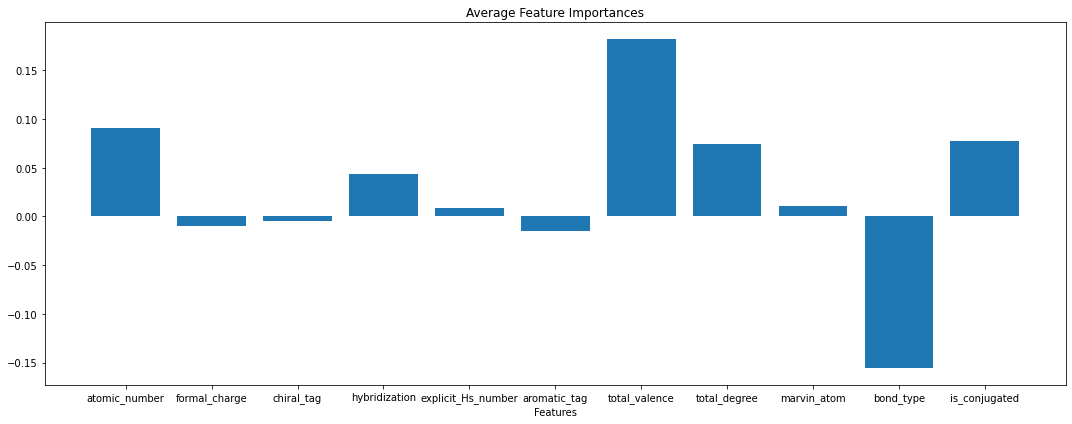

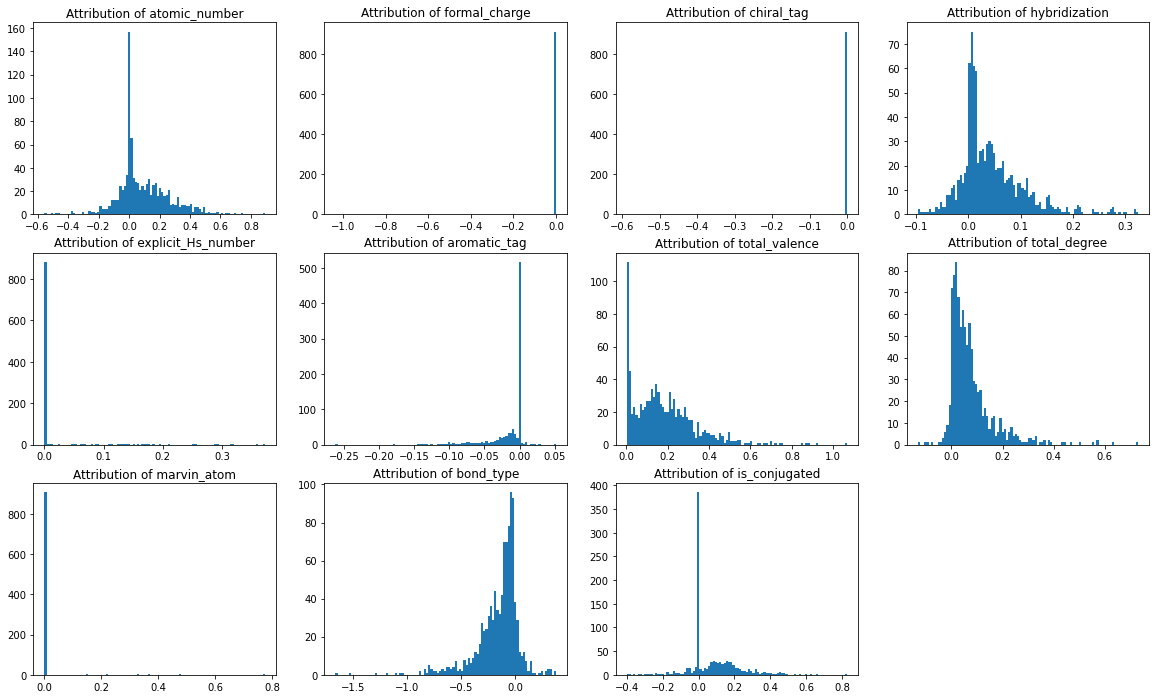

In [19]:
ig = IntegratedGradients(model)
attr_n, attr_e  = calc_importances(ig, dataset, 50)
visualize_importances(node_features, edge_features, np.mean(attr_n, axis=0), np.mean(attr_e, axis=0))
show_importances_distribution(node_features, attr_n, edge_features, attr_e)

In [ ]:
#Paired Model
model_p = GCN(hidden_channels=32).to(device=device)
model_d = GCN(hidden_channels=32).to(device=device)
print(model_p, model_d)

In [ ]:
params = list(model_p.parameters()) + list(model_d.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

# ###
# def train(loader):
#     model.train()
#     for data in loader:  # Iterate in batches over the training dataset. 
#         out = model(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
#         loss = criterion(out.flatten(), data.y)  # Compute the loss.
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad() # Clear gradients.
        
# def test(loader):
#     model.eval()
#     loss = torch.Tensor([0]).to(device=device)
#     for data in loader:  # Iterate in batches over the training dataset.
#         out = model(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
#         loss += criterion_v(out.flatten(), data.y)
#     return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches
# ###


def train(loader):
    model_p.train()
    model_d.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        prot_out = model_p(data.x, data.edge_attr, data.edge_index, data.x_batch) # Perform a single forward pass.
        #print(data.x, data.edge_index, data.x_batch,  data.edge_attr) 
        deprot_out = model_d(data.x2, data.edge_attr2, data.edge_index2, data.x2_batch)
        #out = prot_out 
        out = torch.log10(torch.div(deprot_out, prot_out))
        #print('prot_out',out)
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        
def test(loader):
    model_p.eval()
    model_d.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:  # Iterate in batches over the training dataset.
        #data.to(device="cpu")
        prot_out = model_p(data.x, data.edge_attr, data.edge_index, data.x_batch)  # Perform a single forward pass.
        deprot_out = model_d(data.x2,  data.edge_attr2, data.edge_index2, data.x2_batch)
        out = torch.log10(torch.div(deprot_out, prot_out))
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches
     
for epoch in range(0, num_epochs):
    if epoch != 0: 
        train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}')